## Imports

In [29]:
import matplotlib.pyplot as plt

import numpy as np
import sympy as sp

import os
import sys

sys.path.append(os.path.abspath('..'))

from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating Data

In [30]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.1, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2


num_samples = 1_000
noise = 10
etas_train, gs_train = generate_log_data(SSG_gen, log, 100, shuffle=True, gen_type="add_in_noise", noise=noise, num_samples=num_samples)

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


## Plotting

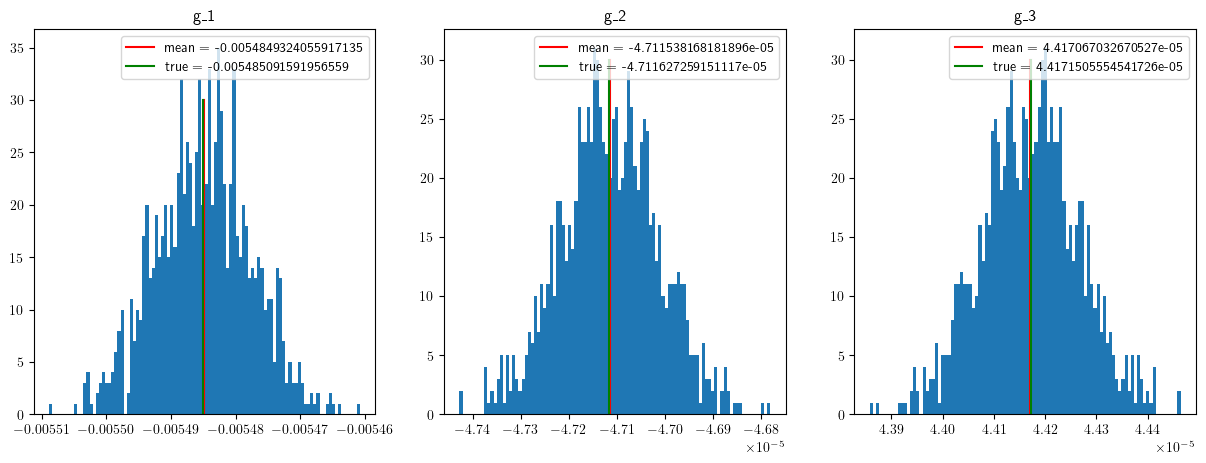

In [31]:
index = np.random.randint(0, len(etas_train))
g_s = gs_train[index]
g_samples = g_s[:, :-1]
g_true = g_s[:, -1]

means = np.mean(g_samples, axis=1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))


ax[0].hist(g_samples[0,:], bins=100)
ax[0].plot(means[0].repeat(100), np.linspace(0, 30, 100), color="red", label=f"mean = {means[0]}")
ax[0].plot(g_true[0].repeat(100), np.linspace(0, 30, 100), color="green", label=f"true = {g_true[0]}")
ax[0].set_title("g_1")
ax[0].legend()

ax[1].hist(g_samples[1,:], bins=100)
ax[1].plot(means[1].repeat(100), np.linspace(0, 30, 100), color="red", label=f"mean = {means[1]}")
ax[1].plot(g_true[1].repeat(100), np.linspace(0, 30, 100), color="green", label=f"true = {g_true[1]}")
ax[1].set_title("g_2")
ax[1].legend()

ax[2].hist(g_samples[2,:], bins=100)
ax[2].plot(means[2].repeat(100), np.linspace(0, 30, 100), color="red", label=f"mean = {means[2]}")
ax[2].plot(g_true[2].repeat(100), np.linspace(0, 30, 100), color="green", label=f"true = {g_true[2]}")
ax[2].set_title("g_3")
ax[2].legend()

plt.show()

(2,) (3, 1001)
[[ 1.37444899e-09  3.71492221e-10 -3.48273957e-10]
 [ 3.71492221e-10  2.77126260e-10 -2.59805869e-10]
 [-3.48273957e-10 -2.59805869e-10  2.43568002e-10]]


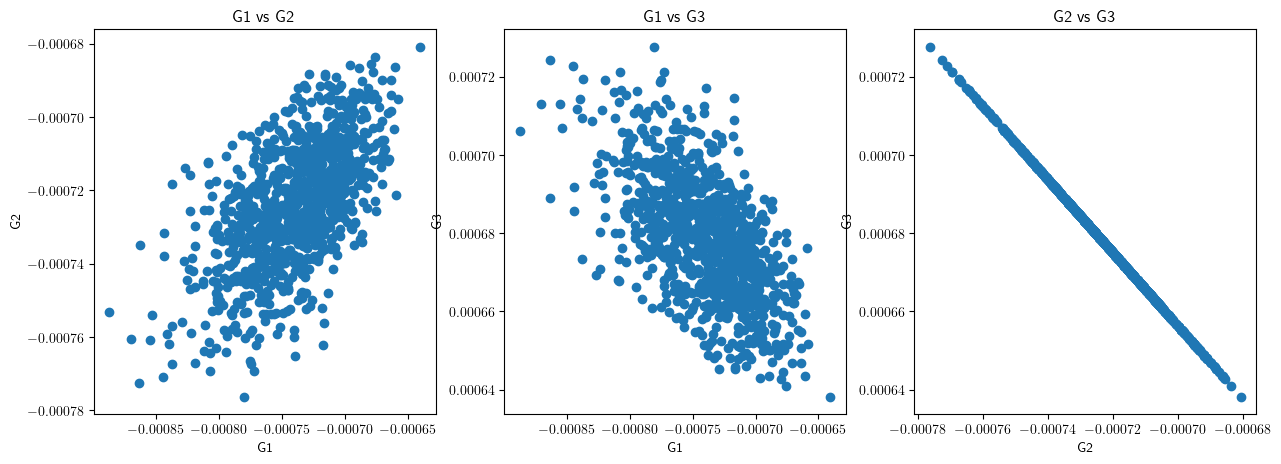

In [32]:
index = np.random.randint(0, etas_train.shape[0])
etas = etas_train[index]
g_s = gs_train[index]
print(etas.shape, g_s.shape)

cov = np.cov(g_s)
print(cov)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(g_s[0,:], g_s[1,:])
axs[0].set_title("G1 vs G2")
axs[0].set_xlabel("G1")
axs[0].set_ylabel("G2")

axs[1].scatter(g_s[0,:], g_s[2,:])
axs[1].set_title("G1 vs G3")
axs[1].set_xlabel("G1")
axs[1].set_ylabel("G3")

axs[2].scatter(g_s[1,:], g_s[2,:])
axs[2].set_title("G2 vs G3")
axs[2].set_xlabel("G2")
axs[2].set_ylabel("G3")

plt.show()


## Sympy Solving

In [31]:
sigma = sp.symbols('sigma')
cov_x = sp.Matrix([[sigma, 0], [0, sigma]])

x_1, x_2 = sp.symbols('x_1 x_2')

C_1_0 = 3.4
C_1_1 = 1.8
C_2 = 0.36
C_3 = 1.25
C_4 = 0.4

L_1_0 = C_1_0/2 - 1
L_1_1 = C_1_1 + 2
L_2 = C_2/2 - (2/3)
L_3 = C_3/2 - 1
L_4 = C_4/2 - 1

p = -((2*L_1_0)/(x_1 * L_1_1))
q = (1/(x_1*L_1_1)**2)*((L_1_0)**2 + x_1*L_1_1*L_2 - (2/3)*x_1*(L_3)**2 + 2*x_2*(L_4)**2)
r = -((L_1_0*L_2)/(x_1 * L_1_1)**2)

a = (q - p**2/3)
b = (1/27)*(2*p**3 - 9*p*q + 27*r)

D = (b**2/4) + (a**3/27)
theta = sp.acos(-b/(2*sp.sqrt(-a**3/27)))

## D > 0 case
y_1_1 = -(p/3) + (-b/2 + sp.sqrt(D))**(1/3) + (-b/2 - sp.sqrt(D))**(1/3)
y_2_1 = -((L_4*y_1_1)/(L_1_0 - x_1*L_1_1*y_1_1))
y_3_1 = ((2*L_3*y_1_1)/(L_1_0 - x_1*L_1_1*y_1_1))


J = sp.Matrix([[sp.diff(y_1_1, x_1), sp.diff(y_1_1, x_2)], [sp.diff(y_2_1, x_1), sp.diff(y_2_1, x_2)], [sp.diff(y_3_1, x_1), sp.diff(y_3_1, x_2)]])
cov_1 = J*cov_x*J.T

## D < 0 case

## b < 0

y_1_2 = -(p/3) + 2*sp.sqrt(-a/3)*sp.cos(theta/3)
y_2_2 = -((L_4*y_1_2)/(L_1_0 - x_1*L_1_1*y_1_2))
y_3_2 = ((2*L_3*y_1_2)/(L_1_0 - x_1*L_1_1*y_1_2))

J = sp.Matrix([[sp.diff(y_1_2, x_1), sp.diff(y_1_2, x_2)], [sp.diff(y_2_2, x_1), sp.diff(y_2_2, x_2)], [sp.diff(y_3_2, x_1), sp.diff(y_3_2, x_2)]])
cov_2 = J*cov_x*J.T

## b > 0

y_1_3 = -(p/3) + 2*sp.sqrt(-a/3)*sp.cos((theta + 2*sp.pi)/3)
y_2_3 = -((L_4*y_1_3)/(L_1_0 - x_1*L_1_1*y_1_3))
y_3_3 = ((2*L_3*y_1_3)/(L_1_0 - x_1*L_1_1*y_1_3))

J = sp.Matrix([[sp.diff(y_1_3, x_1), sp.diff(y_1_3, x_2)], [sp.diff(y_2_3, x_1), sp.diff(y_2_3, x_2)], [sp.diff(y_3_3, x_1), sp.diff(y_3_3, x_2)]])
cov_3 = J*cov_x*J.T

cov_1 = cov_1.subs({x_1: etas[0], x_2: etas[1], sigma: noise})
cov_2 = cov_2.subs({x_1: etas[0], x_2: etas[1], sigma: noise})
cov_3 = cov_3.subs({x_1: etas[0], x_2: etas[1], sigma: noise})

sp.pprint(cov_1)
sp.pprint(cov_2)
sp.pprint(cov_3)

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                             ⎛                               
⎢0.1⋅(-2798.48347202119 - 1615.70518142965⋅ⅈ)⋅⎜-0.00351020732414582⋅(-14.43901
⎢                                             ⎜                               
⎢                                             ⎝                               
⎢                                                                             
⎢                                                                             
⎢                                               ⎛   